# IMPORT LIBRARIES/DATASETS

In [222]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import os


In [223]:
#look at folders names
os.listdir('datasets/Osteoporosis-2-1/train')

['normal', 'osteoporosis']

In [224]:
#look at folders names
os.listdir('datasets/Osteoporosis-2-1/valid')

['normal', 'osteoporosis']

In [226]:
# check the number of images in training, validation and test dataset

train = []
test = []
train_path = 'datasets/Osteoporosis-2-1/train'
valid_path = 'datasets/Osteoporosis-2-1/valid'
test_path = 'datasets/Osteoporosis-2-1/test'

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir(train_path):
  train_class = os.listdir(os.path.join(train_path, i))
  train.extend(train_class)
  test_class = os.listdir(os.path.join(test_path, i))
  test.extend(test_class)


print('Number of train images : {} \nNumber of test images : {}'.format(len(train), len(test)))


Number of train images : 442 
Number of test images : 59


In [181]:
train[:20]

['101_jpg.rf.b64bea3976848212490351d0ca656534.jpg',
 '104_jpg.rf.840467826f9267fb4a9e46acf2b1a984.jpg',
 '110_jpg.rf.0a8ef54be8929e344eab694912aa0adf.jpg',
 '115n_JPEG.rf.f3efabda7f4a3b33792e947662df58c4.jpg',
 '11nn_png.rf.3625026e9b8c527d4ff29366493c2f61.jpg',
 '11_jpg.rf.222cd6f349396f26c9505b307a8f7bdf.jpg',
 '123_png.rf.f6819487bbbaa1c75b8a171794e8dbfb.jpg',
 '125_jpg.rf.4340084b28bd5e70ebcca732acf3a772.jpg',
 '128_jpg.rf.c6b43b8e68b294e58f8e51f5e693e71f.jpg',
 '12_png.rf.be1707a8dc35418960a9c4aa48ddc235.jpg',
 '131_jpg.rf.65f0644eff63f8b79a6f56ada8462bdb.jpg',
 '132_png.rf.deb0c646d7b6631424de281caea80ab7.jpg',
 '133_jpg.rf.cfd8f2e0ad4c6504f5ecb97dd0c024cb.jpg',
 '135_jpg.rf.6850e554cc7bf4971aec0c6a7a4508d9.jpg',
 '137_jpg.rf.566038cb2ef35286a98e915bbe30e46f.jpg',
 '138_png.rf.b459ee07a0b7db66c49925d4956a4436.jpg',
 '139_jpg.rf.6a5a1185df9ad3aee1e0b4406cc394c5.jpg',
 '13_png.rf.25344e3bf914914817d5f0d57f1540ce.jpg',
 '140_png.rf.1527f5542f44cd8c7a65641ea697d350.jpg',
 '141_jpg.rf

# DATA EXPLORATION AND DATA VISUALIZATION

In [227]:
# check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []
for i in os.listdir(train_path):
  train_class = os.listdir(os.path.join(train_path, i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in normal = 229 

Number of images in osteoporosis = 213 



In [228]:
Class_name

['normal', 'osteoporosis']

In [229]:
No_images_per_class

[229, 213]

<function matplotlib.pyplot.show(close=None, block=None)>

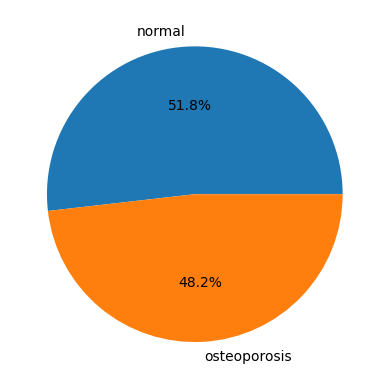

In [230]:
# visualize class distribution in train set
fig1, ax1 = plt.subplots()
ax1.pie(No_images_per_class, labels = Class_name, autopct = '%1.1f%%')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

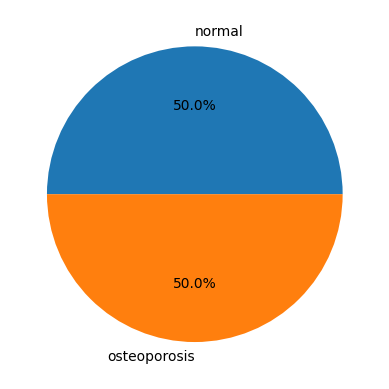

In [186]:
# plot pie chart of the test set
No_images_per_class = []
Class_name = []
for i in os.listdir(test_path):
  train_class = os.listdir(os.path.join(test_path,i))
  No_images_per_class.append(len(test_class))
  Class_name.append(i)

fig1, ax1 = plt.subplots()
ax1.pie(No_images_per_class, labels = Class_name, autopct = '%1.1f%%')
plt.show

# PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [231]:
# create run-time augmentation on training and test dataset
# for training datagenerator, we add normalization, shear angle, zooming range and horizontal flip
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        #validation_split=0.15,
        horizontal_flip=True)


# for test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale=1./255)

In [244]:
# create datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary',)

validation_generator = train_datagen.flow_from_directory(
        valid_path,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary',)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary')

X_batch, y_batch = next(train_generator)
print(y_batch.shape)

Found 442 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


Found 59 images belonging to 2 classes.
(32,)


# BUILD RESNET MODEL

In [234]:
def res_block(X, filter, stage):
  
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [245]:
# input shape
input_shape = (256,256,3)

# input tensor shape
X_input = Input(input_shape)

# zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage
X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage
X = res_block(X, filter= [256,256,1024], stage= 4)

# 5- stage
X = res_block(X, filter= [512,512,2048], stage= 5)

# average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# final layer
X = Flatten()(X)
X = Dense(1, activation = 'sigmoid', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

# create model
model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

# model summary
model.summary()

Model: "Resnet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_11   │ (None, 262, 262,  │          0 │ input_layer_60[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 128, 128,  │      9,472 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 128, 128,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_407      │ (None, 128, 128,  │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_97    │ (None, 63, 63,    │          0 │ activation_407[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_a        │ (None, 63, 63,    │      4,160 │ max_pooling2d_97… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_98    │ (None, 31, 31,    │          0 │ res_2_conv_a[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_a         │ (None, 31, 31,    │        256 │ max_pooling2d_98… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_408      │ (None, 31, 31,    │          0 │ bn_2_conv_a[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_b        │ (None, 31, 31,    │     36,928 │ activation_408[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_b         │ (None, 31, 31,    │        256 │ res_2_conv_b[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_409      │ (None, 31, 31,    │          0 │ bn_2_conv_b[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_copy     │ (None, 63, 63,    │     16,640 │ max_pooling2d_97… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_c        │ (None, 31, 31,    │     16,640 │ activation_409[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_99    │ (None, 31, 31,    │          0 │ res_2_conv_copy[… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_c         │ (None, 31, 31,    │      1,024 │ res_2_conv_c[0][

 Total params: 19,942,017 (76.07 MB)

 Trainable params: 19,899,649 (75.91 MB)

 Non-trainable params: 42,368 (165.50 KB)

# COMPILE AND TRAIN DEEP LEARNING MODEL

In [246]:
# compile
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])

In [264]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=15)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.keras", verbose=1, save_best_only=True)

In [265]:
# fit
history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.n // 32, 
                    epochs=25, 
                    validation_data=validation_generator, 
                    validation_steps=validation_generator.n // 32, 
                    callbacks=[checkpointer , earlystopping])

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9581 - loss: 0.1060
Epoch 1: val_loss improved from inf to 1.06117, saving model to weights.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9571 - loss: 0.1078 - val_accuracy: 0.4479 - val_loss: 1.0612
Epoch 2/25
 1/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9688 - loss: 0.1281

c:\Users\ffmic\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.06117 to 0.51404, saving model to weights.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9688 - loss: 0.0690 - val_accuracy: 0.5000 - val_loss: 0.5140
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9585 - loss: 0.1307
Epoch 3: val_loss did not improve from 0.51404
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9578 - loss: 0.1304 - val_accuracy: 0.4583 - val_loss: 1.1300
Epoch 4/25
 1/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9375 - loss: 0.1051
Epoch 4: val_loss did not improve from 0.51404
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9375 - loss: 0.0566 - val_accuracy: 0.4444 - val_loss: 0.5650
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9740 - loss: 0.0845
Epoch 5: val_loss did not improve from 0.51404
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9734 - loss: 0.0858 - val_accuracy: 0.4792 - val_loss: 1.1341
Epoch 6/25
 1/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0

# ASSESS THE PERFORMANCE OF THE TRAINED MODEL

In [266]:
# load previously trained model
model.load_weights('weights.keras')

In [267]:
# evaluate the performance of the model
print('Train loss & accuracy:', model.evaluate(train_generator))
print('\n')
print('Test loss & accuracy:', model.evaluate(test_generator))

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 517ms/step - accuracy: 0.6686 - loss: 0.6565
Train loss & accuracy: [0.6564651131629944, 0.6606335043907166]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step - accuracy: 0.6916 - loss: 0.6582
Test loss & accuracy: [0.6690047979354858, 0.6779661178588867]


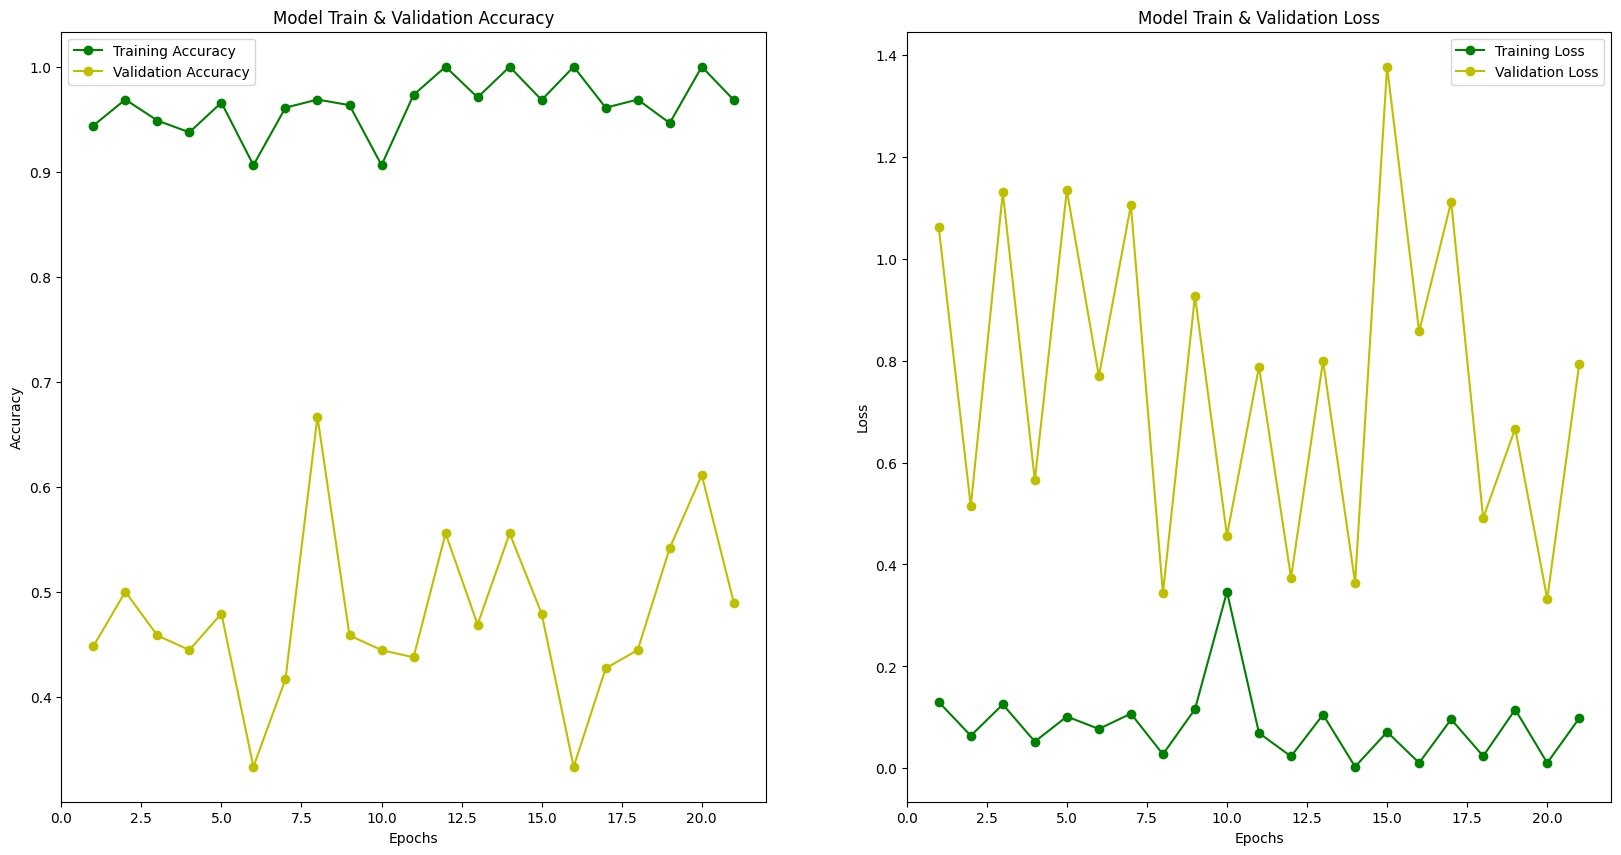

In [268]:
# plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [269]:
# assign label names to the corresponding indexes
labels = {0: 'normal', 1: 'Osterporosis'}

In [270]:
# load images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0
for i in os.listdir(test_path):
  for item in os.listdir(os.path.join(test_path, i)):
    # code to open the image
    img= PIL.Image.open(os.path.join(test_path, i, item))
    # resizing the image to (256,256)
    img = img.resize((256, 256))
    # appending image to the image list
    image.append(img)
    # converting image to array
    img = np.asarray(img, dtype = np.float32)
    # normalizing the image
    img = img / 255
    # reshaping the image into a 4D array
    img = img.reshape(-1, 256, 256, 3)
    # making prediction of the model
    predict = model.predict(img)
    # getting the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    # appending the predicted class to the list
    prediction.append(labels[predict])
    # appending original class to the list
    original.append(i)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

In [275]:
# get the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.4745762711864407


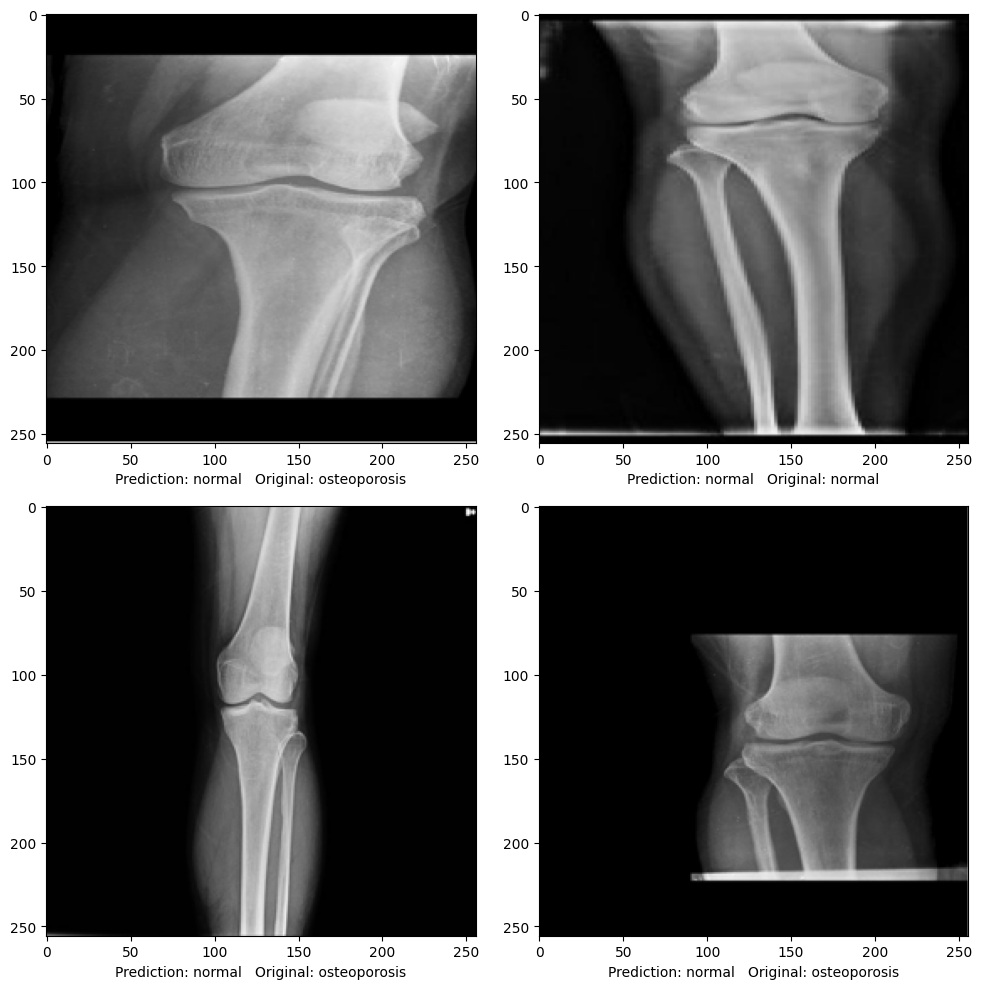

In [277]:
# visualize the results
import random
fig = plt.figure(figsize = (10,10))
for i in range(4):
    j = random.randint(0, len(image))
    fig.add_subplot(2, 2, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [278]:
# print the classiication report
print(classification_report(np.asarray(prediction), np.asarray(original)))

              precision    recall  f1-score   support

      normal       1.00      0.47      0.64        59
osteoporosis       0.00      0.00      0.00         0

    accuracy                           0.47        59
   macro avg       0.50      0.24      0.32        59
weighted avg       1.00      0.47      0.64        59



c:\Users\ffmic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ffmic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ffmic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Text(0.5, 1.0, 'Confusion_matrix')

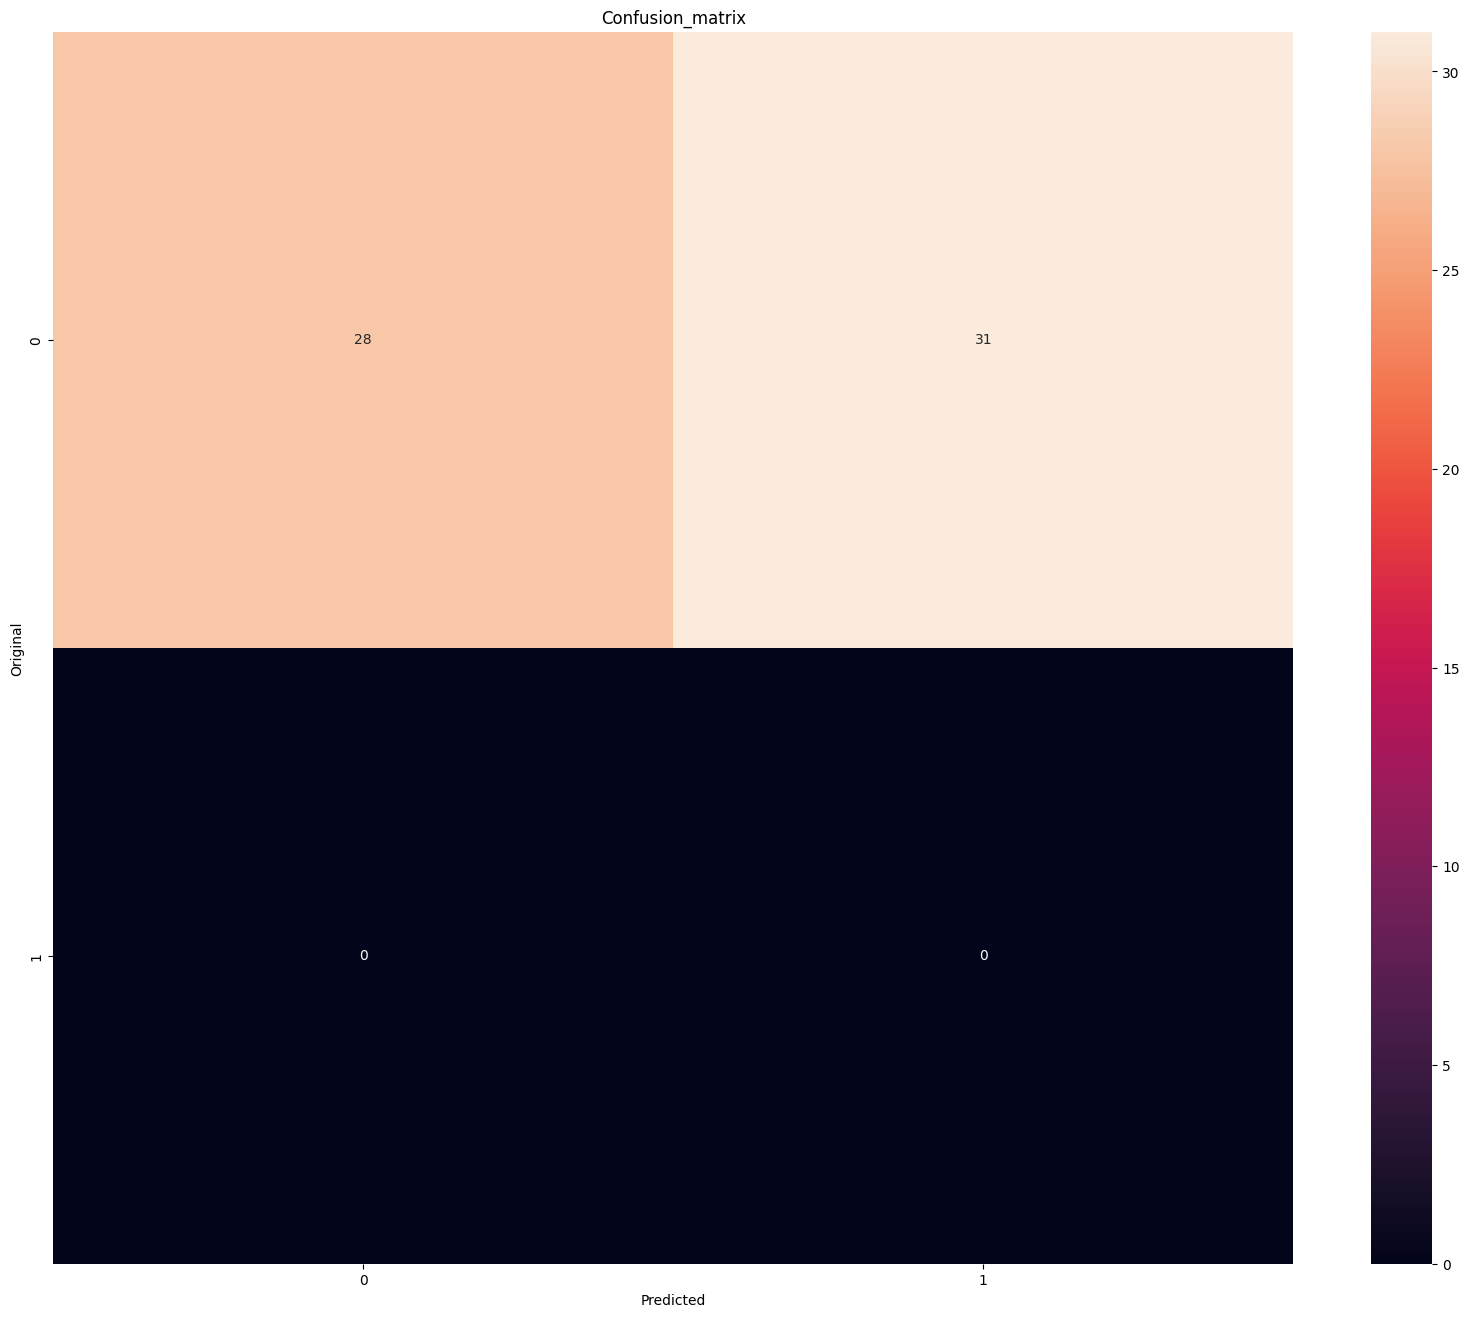

In [279]:
# plot the confusion matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(np.asarray(prediction), np.asarray(original))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

# VISUALIZING ACTIVATION MAPS THROUGH GRAD-CAM

In [280]:
def grad_cam(img):

  # convert the image to array of type float32
  img = np.asarray(img, dtype = np.float32)

  # reshape the image from (256,256,3) to (1,256,256,3)
  img = img.reshape(-1, 256, 256, 3)
  img_scaled = img / 255

  # name of the average pooling layer and dense final (you can see these names in the model summary)
  classification_layers = ["Averagea_Pooling", "Dense_final"]

  # last convolutional layer in the model
  final_conv = model.get_layer("res_5_identity_2_c")

  # create a model with original model inputs and the last conv_layer as the output
  final_conv_model = keras.Model(model.inputs, final_conv.output)

  # then we create the input for classification layer, which is the output of last conv layer
  # in our case, output produced by the conv layer is of the shape (1,3,3,2048) 
  # since the classification input needs the features as input, we ignore the batch dimension

  classification_input = keras.Input(shape = final_conv.output.shape[1:])

  # we iterate through the classification layers, to get the final layer and then append 
  # the layer as the output layer to the classification model.
  temp = classification_input
  for layer in classification_layers:
      temp = model.get_layer(layer)(temp)
  classification_model = keras.Model(classification_input, temp)


  # we use gradient tape to monitor the 'final_conv_output' to retrive the gradients
  # corresponding to the predicted class
  with tf.GradientTape() as tape:
      # Pass the image through the base model and get the feature map 
      final_conv_output = final_conv_model(img_scaled)

      # Assign gradient tape to monitor the conv_output
      tape.watch(final_conv_output)
      
      # pass the feature map through the classification model and use argmax to get the 
      # index of the predicted class and then use the index to get the value produced by final
      # layer for that class
      prediction = classification_model(final_conv_output)

      predicted_class = tf.argmax(prediction[0][0][0])

      predicted_class_value = prediction[:,:,:,predicted_class]
  
  # get the gradient corresponding to the predicted class based on feature map.
  # which is of shape (1,3,3,2048)
  gradient = tape.gradient(predicted_class_value, final_conv_output)

  # since we need the filter values (2048), we reduce the other dimensions, 
  # which would result in a shape of (2048,)
  gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  # we then convert the feature map produced by last conv layer(1,6,6,1536) to (6,6,1536)
  final_conv_output = final_conv_output.numpy()[0]

  gradient_channels = gradient_channels.numpy()

  # we multiply the filters in the feature map produced by final conv layer by the 
  # filter values that are used to get the predicted class. By doing this we inrease the
  # value of areas that helped in making the prediction and lower the vlaue of areas, that 
  # did not contribute towards the final prediction
  for i in range(gradient_channels.shape[-1]):
      final_conv_output[:, :, i] *= gradient_channels[i]

  # we take the mean accross the channels to get the feature map
  heatmap = np.mean(final_conv_output, axis=-1)

  # normalizing the heat map between 0 and 1, to visualize it
  heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # rescaling and converting the type to int
  heatmap = np.uint8(255 * heatmap_normalized )

  # create the colormap
  color_map = plt.cm.get_cmap('jet')

  # get only the rb features from the heatmap
  color_map = color_map(np.arange(256))[:, :3]
  heatmap = color_map[heatmap]

  # convert the array to image, resize the image and then convert to array
  heatmap = keras.preprocessing.image.array_to_img(heatmap)
  heatmap = heatmap.resize((256, 256))
  heatmap = np.asarray(heatmap, dtype = np.float32)

  # add the heatmap on top of the original image
  final_img = heatmap * 0.4 + img[0]
  final_img = keras.preprocessing.image.array_to_img(final_img)

  return final_img, heatmap_normalized


C:\Users\ffmic\AppData\Local\Temp\ipykernel_6388\963071781.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('jet')


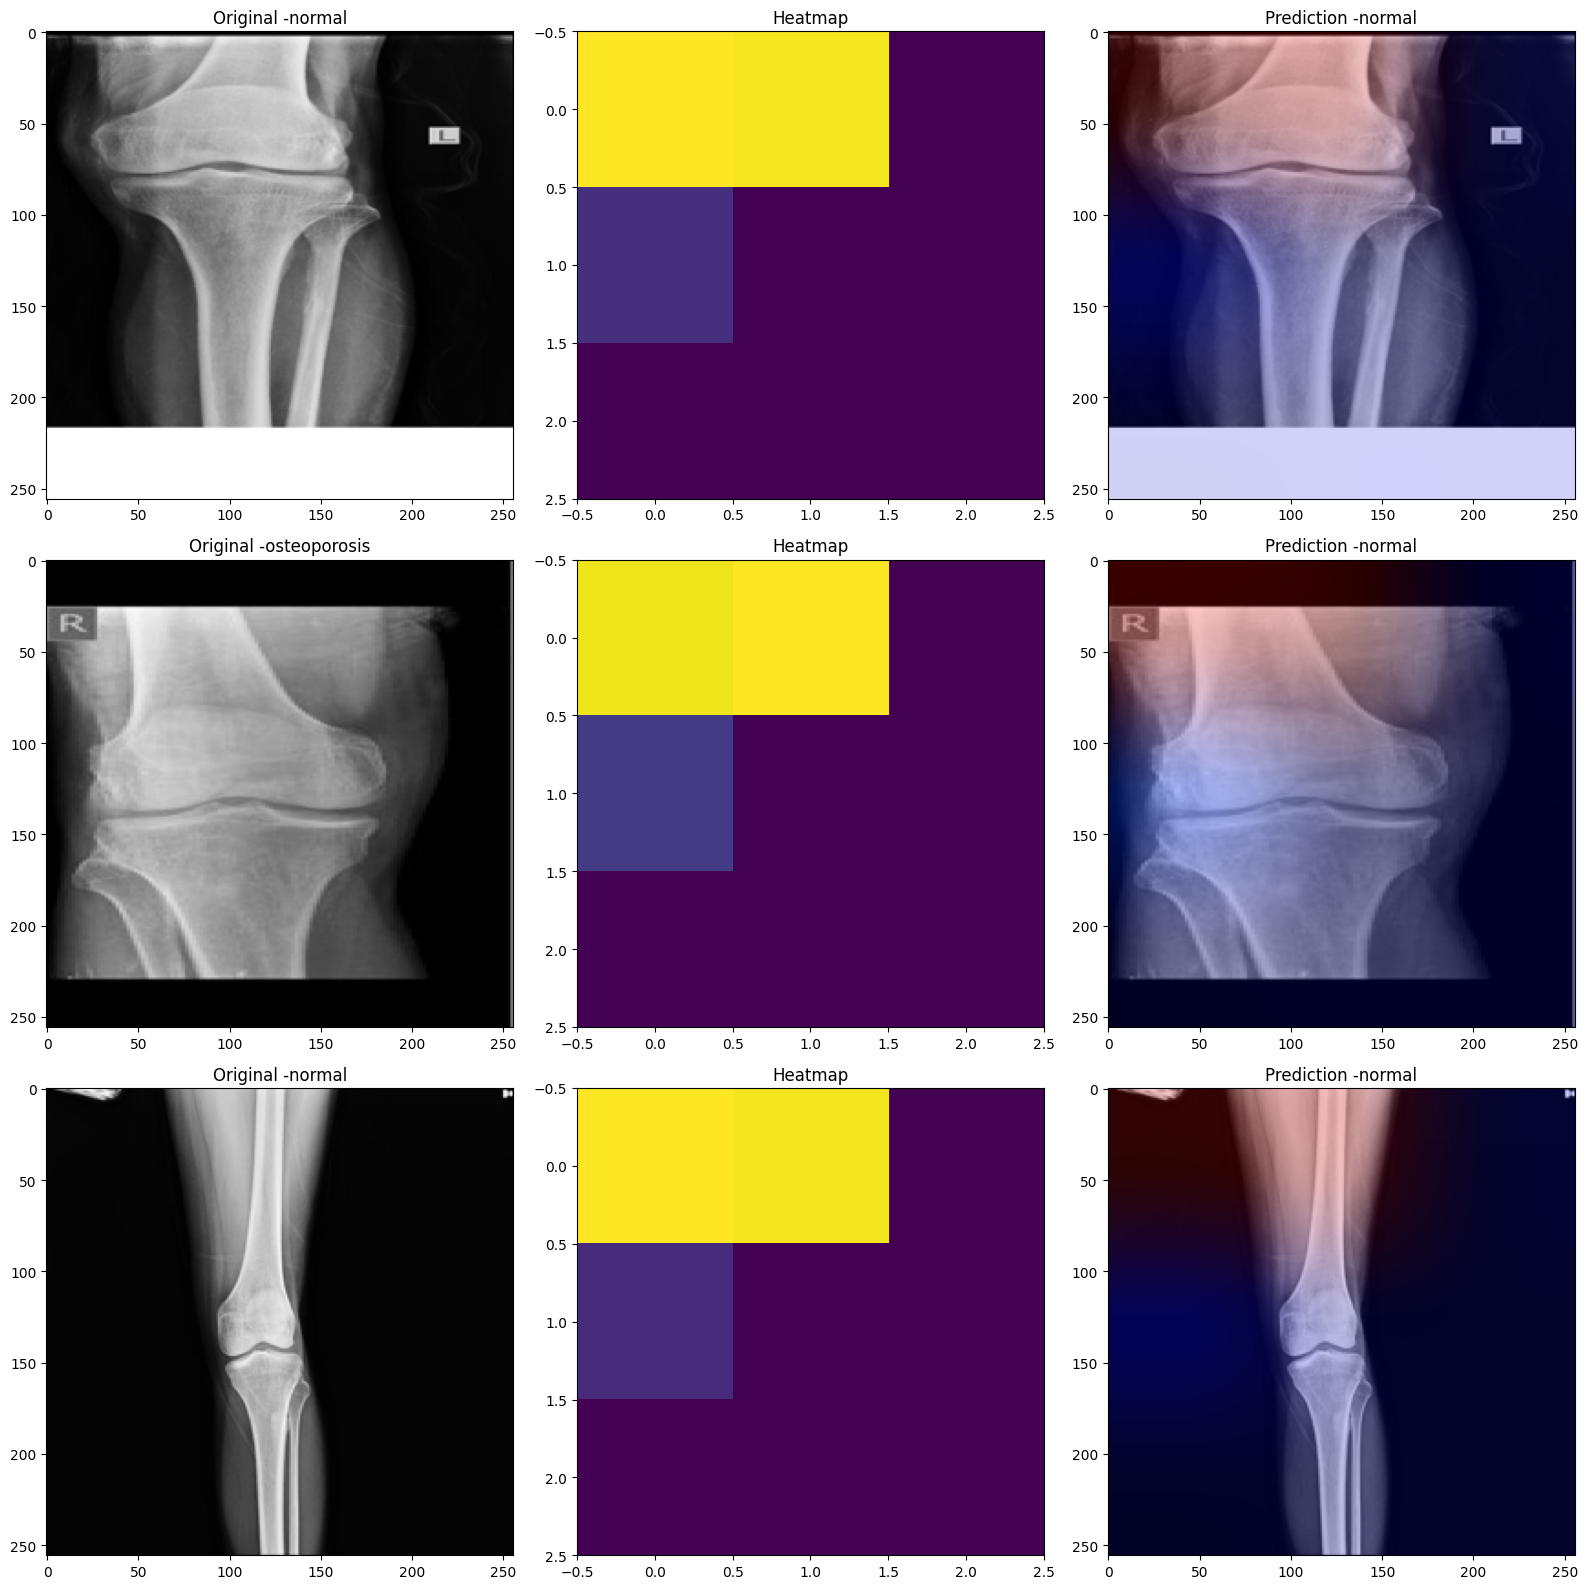

In [281]:
# visualize the images in the dataset
import random
fig, axs = plt.subplots(3,3, figsize = (16,16))
count = 0
for _ in range(3):
  i = random.randint(0, len(image))
  gradcam, heatmap = grad_cam(image[i])
  axs[count][0].title.set_text("Original -" + original[i])
  axs[count][0].imshow(image[i])
  axs[count][1].title.set_text("Heatmap") 
  axs[count][1].imshow(heatmap)
  axs[count][2].title.set_text("Prediction -" + prediction[i]) 
  axs[count][2].imshow(gradcam)  
  count += 1

fig.tight_layout()